# Predicting Order Demand
Predict order demand based on product type, warehouse location, product category, and time series information.
___

In [285]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import calendar
import datetime
from datetime import date
from sklearn.model_selection import train_test_split

## Read in and Clean the Data Set
___
- Read in the data as a time series.
- Fill in NA values with the last valid observation.
- Format negative numbers correctly.

In [286]:
# Read in the data set as a time series by converting the values in the
# Date column to datetimes and using them as the indices.
hpd = pd.read_csv(
    '../data/Historical Product Demand.csv',
    index_col='Date',
    parse_dates=['Date']
)

# Fill NA values with the last valid observation.
hpd = hpd.fillna(method='ffill')

# Negative numbers are currently surrounded in paraentheses in the dataset.
# Remove the parentheses and add the negative sign.
hpd['Order_Demand'].replace('[(]', '-', inplace=True, regex=True)
hpd['Order_Demand'].replace('[)]', '', inplace=True, regex=True)
hpd['Order_Demand'] = hpd['Order_Demand'].astype(int)

hpd.head(3)

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100
2012-01-19,Product_0979,Whse_J,Category_028,500
2012-02-03,Product_0979,Whse_J,Category_028,500


## Exploratory Data Analysis
___
Define a function that will plot the following:
- Order demand vs. date.
- Average daily order demand vs. day of year.
  - For example, the average order demand of all of the rows with an index of 1/1/2012 will be plotted at day 1 for 2012. 

In [287]:
def plotOrderDemand(df, title):
    fig = plt.figure(figsize=(15,4))

    # Plot Order_Demand vs. Date
    ax1 = fig.add_subplot(121)
    df["Order_Demand"].plot(ax=ax1)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Order Demand")

    # For every year, Plot average daily Order_Demand vs. day of year
    ax2 = fig.add_subplot(122)
    pv = pd.pivot_table(
        df,
        index=df.index.dayofyear,
        columns=df.index.year,
        aggfunc=np.mean,
        fill_value=0
    )
    pv.plot(ax=ax2)
    plt.title(title)
    plt.xlabel("Day of Year")
    plt.ylabel("Average Daily Order Demand")
    plt.legend(labels=("2011", "2012", "2013", "2014", "2015", "2016", "2017"), loc=2)
    plt.show()

### 1. Plot Order Demand vs. Date for Entire Data Set

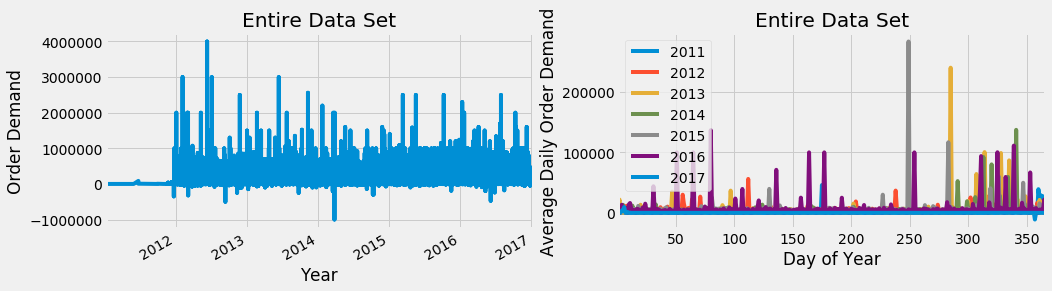

In [288]:
plotOrderDemand(hpd, "Entire Data Set")

### 2. Plot Order Demand vs. Date for Different Warehouses

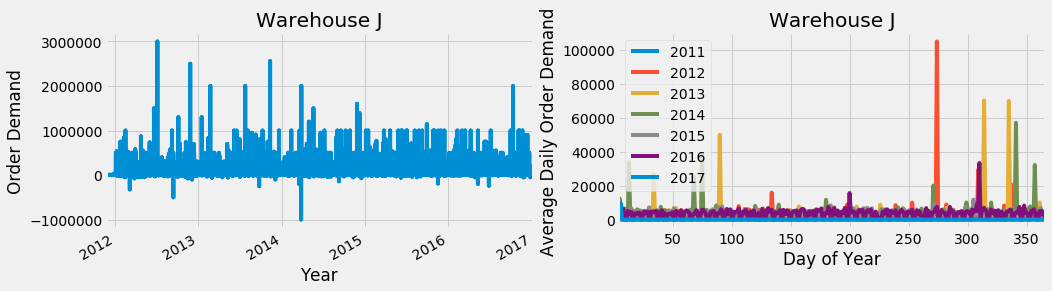

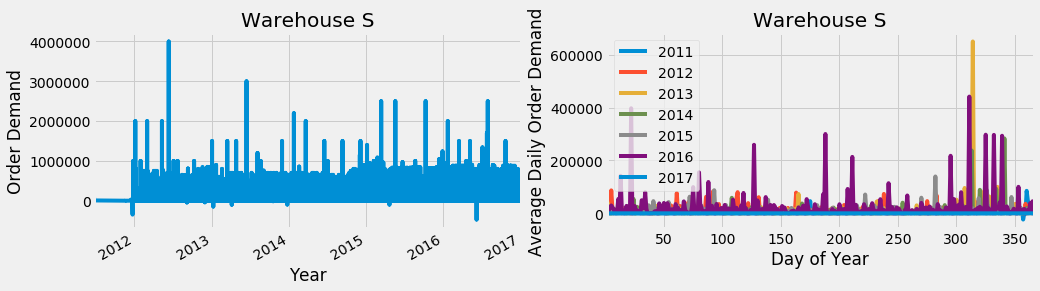

In [289]:
plotOrderDemand(hpd.loc[hpd["Warehouse"] == "Whse_J"], "Warehouse J")
plotOrderDemand(hpd.loc[hpd["Warehouse"] == "Whse_S"], "Warehouse S")

### 3. Plot Order Demand vs. Date for Different Categories

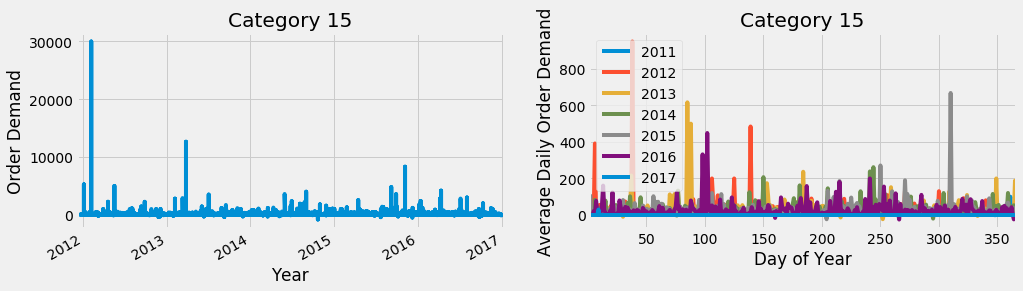

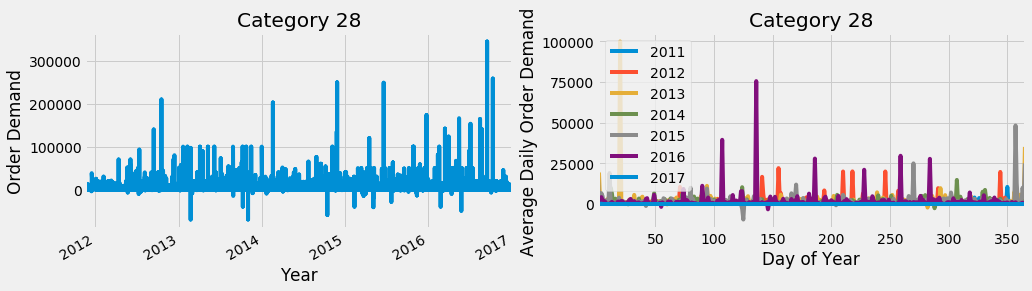

In [290]:
plotOrderDemand(hpd.loc[hpd["Product_Category"] == "Category_015"], "Category 15")
plotOrderDemand(hpd.loc[hpd["Product_Category"] == "Category_028"], "Category 28")

### 4. Plot Order Demand vs. Date for Different Products

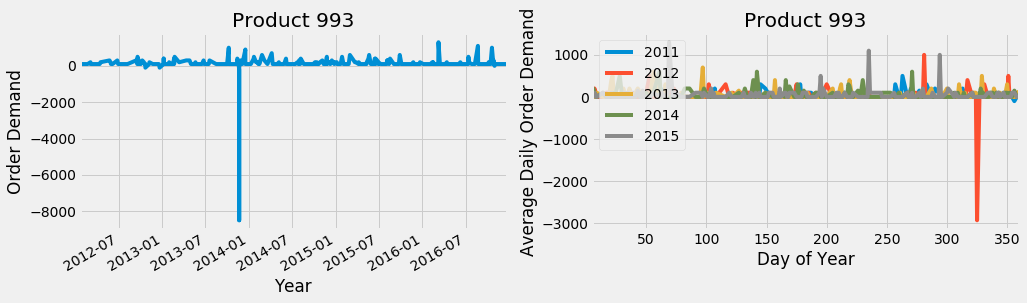

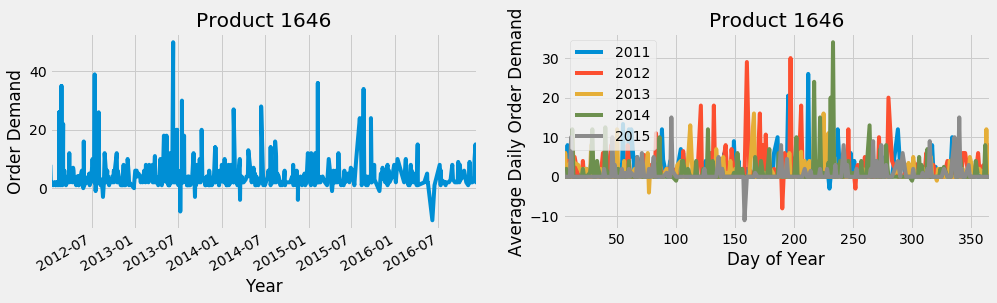

In [291]:
plotOrderDemand(hpd.loc[hpd["Product_Code"] == "Product_0993"], "Product 993")
plotOrderDemand(hpd.loc[hpd["Product_Code"] == "Product_1646"], "Product 1646")

### Conclusions:
- Different order demand trends vary for different warehouses, and categories, and products.
- Order demand often has sudden spikes.
  - This is hard for models to predict.
  - Training models with spiked data can hurt their accuracy.

## Feature Engineering
___
### 1. Remove Outliers
For each category, remove values that are more than 3 standard deviations away from that category's mean order demand. This will allow us to test if outliers skew the models and hurt accuracy. Store the outlier-free data set in hpdWOO, which stands for historical product demand without outliers. 

In [292]:
# hpdWOO = hpd without outliers
hpdWOO = hpd 

# For each category, remove outliers
for i in np.unique(hpdWOO["Product_Category"].values):
    # Select rows that have the specified product category
    cat = hpdWOO.loc[hpdWOO["Product_Category"] == i]
    # Keep everything except for rows that are the given category and outside of 3
    # standard deviations of the mean.
    hpdWOO = hpdWOO[(
        (hpdWOO.Product_Category != i) | (
            (hpdWOO.Product_Category == i) & (
                np.abs(hpdWOO.Order_Demand - cat.Order_Demand.mean()) <=
                (3*cat.Order_Demand.std())
            )
        )
    )]

**Plot:** compare the data set with and without outliers.

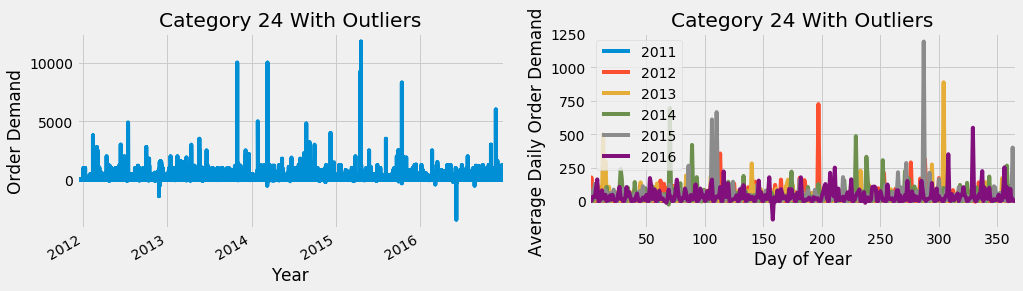

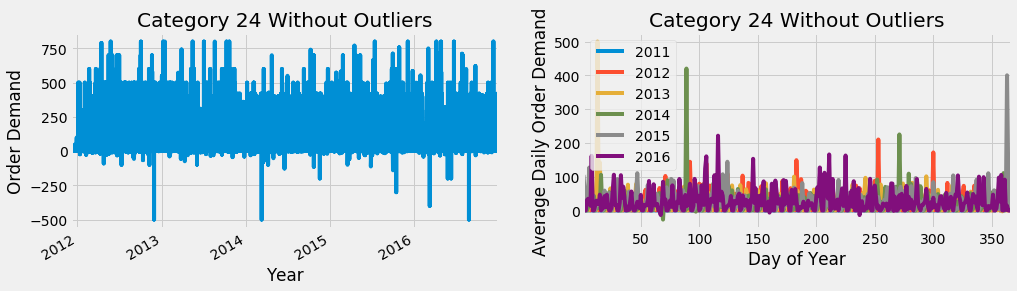

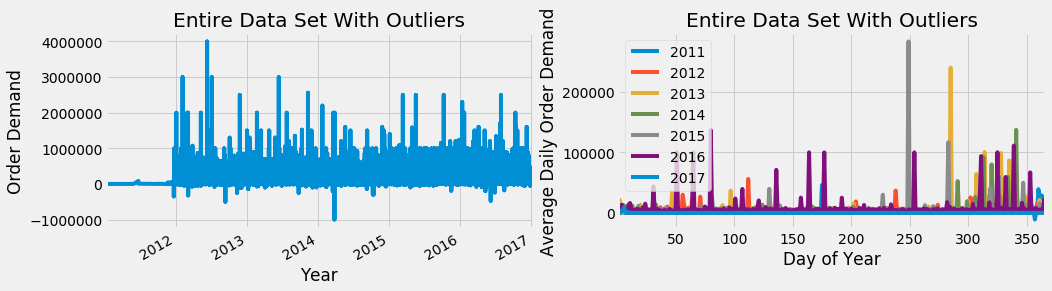

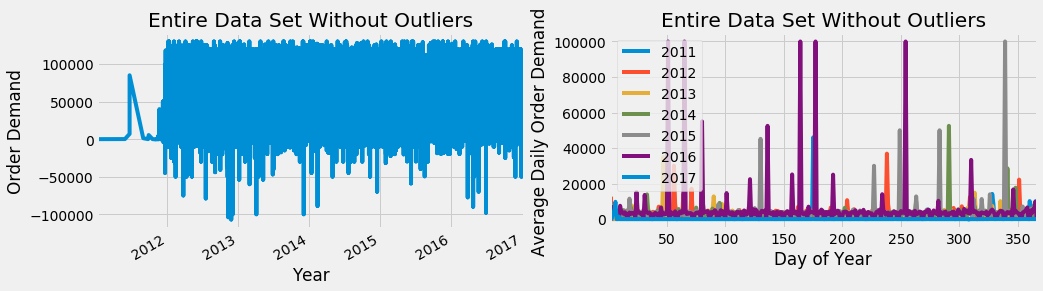

In [293]:
# Compare Category 24 with/without outliers
plotOrderDemand(hpd.loc[hpd["Product_Category"] == "Category_024"], "Category 24 With Outliers")
plotOrderDemand(
    hpdWOO.loc[hpdWOO["Product_Category"] == "Category_024"],
    "Category 24 Without Outliers"
)

# Compare The entire data set with/without outliers
plotOrderDemand(hpd, "Entire Data Set With Outliers")
plotOrderDemand(hpdWOO, "Entire Data Set Without Outliers")

**Conclusion:** removing outliers seems to have made the individual categories more stable. When looking at the entire data set, though, it seems like useful information may have been removed. The original data set seems to be characterized by its spikes. We will see the effects of removing outliers in the models section.

### 2. Make Product, Category, and Warehouse Useable
For hpd and hpdWOO:
- One-hot encode Warehouse.
- Convert product and category into an int.

In [294]:
# One-Hot Encode the warehouse values.
hpd = pd.get_dummies(
    hpd,
    columns=["Warehouse"],
    sparse=True
)
# Remove the "Product_" and "Category_" prefixes.
hpd["Product_Code"] = hpd["Product_Code"].str[8:].astype(int)
hpd["Product_Category"] = hpd["Product_Category"].str[9:].astype(int)


# Do the same for hpdWOO
hpdWOO = pd.get_dummies(
    hpdWOO,
    columns=["Warehouse"],
    sparse=True
)
hpdWOO["Product_Code"] = hpdWOO["Product_Code"].str[8:].astype(int)
hpdWOO["Product_Category"] = hpdWOO["Product_Category"].str[9:].astype(int)

hpd.head(3)

,Product_Code,Product_Category,Order_Demand,Warehouse_Whse_A,Warehouse_Whse_C,Warehouse_Whse_J,Warehouse_Whse_S
Date,,,,,,,
2012-07-27,993,28,100,0,0,1,0
2012-01-19,979,28,500,0,0,1,0
2012-02-03,979,28,500,0,0,1,0


## Models: With vs. Without Outliers
___
Two different data sets will be used to train our regression models:
- **hpd:** the original data set
- **hpdWOO:** the data set where outliers were removed

Then the models will be tested on the test data from hpd. This will assess how accurately each model can predict the testing data from the original data set. This will determine the benefit/drawback of removing outliers from our training data. 

First, sort the two Dataframes so that we will be able to have the older data be used for training and the newer data for testing.

In [295]:
hpd.sort_index(inplace=True)
hpdWOO.sort_index(inplace=True)

Split hpd and hpdWOO into features and targets.

In [296]:
# Split hpd into features and target values
features = [i for i in hpd.columns.tolist() if (i != "Order_Demand")]
target = ["Order_Demand"]
X = hpd[features]
y = hpd[target]

# Split hpdWOO into features and target values
featuresWOO = [i for i in hpdWOO.columns.tolist() if (i != "Order_Demand")]
targetWOO = ["Order_Demand"]
XWOO = hpdWOO[featuresWOO]
yWOO = hpdWOO[targetWOO]

Split the data sets into training and testing sets:
- **Training:** the oldest 66% of the data.
- **Testing:** the newest 34% of the data.

In [297]:
# Set the training size to be 66%
train_size = int(len(X) * 0.66)

# Split hpd into 66% training data and 34% test data.
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

# Split hpdWOO into 66% training data and 34% test data.
XWOO_train, XWOO_test = XWOO[0:train_size], XWOO[train_size:len(X)]
yWOO_train, yWOO_test = yWOO[0:train_size], yWOO[train_size:len(X)]

Create a function that will fit the passed in regression model and print its R^2 score. Train the model with hpd if withOutliers is true; use hpdWOO's training data if withOutliers is False.

In [302]:
from sklearn.metrics import r2_score

# Use the given regressor to fit the training and testing data. If withOutliers is true,
# use hpd's traing data; if it is false, use hpdWOO'S. Then print the R^2 values.
def fitAndPrint(reg, withOutliers):
    if withOutliers:
        reg = reg.fit(X_train, y_train)
    else:
        reg = reg.fit(XWOO_train, yWOO_train)
    print("-Training R^2: %4.4f" %
          r2_score(
              y_train if withOutliers else yWOO_train,
              reg.predict(X_train if withOutliers else XWOO_train),
              multioutput='variance_weighted'
          )
    )
    print("-Testing R^2: %4.4f" %
          r2_score(y_test, reg.predict(X_test), multioutput='variance_weighted')) 

### 1. Linear Regression

In [303]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
print("Linear Regressor With Outliers:")
fitAndPrint(lr, True)

print("Linear Regressor Without Outliers:")
fitAndPrint(lr, False)

Linear Regressor With Outliers:
-Training R^2: 0.0145
-Testing R^2: 0.0155
Linear Regressor Without Outliers:
-Training R^2: 0.0379
-Testing R^2: 0.0079


### 2. Gradient Boosting

In [304]:
import warnings
from sklearn.ensemble import GradientBoostingRegressor

# Suppress stupid DataConversionWarning that wants a 1d array instead of a
# column vector
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    gb = GradientBoostingRegressor()
    print("Gradient Boosting Regressor With Outliers:")
    fitAndPrint(gb, True)

    print("Gradient Boosting Regressor Without Outliers:")
    fitAndPrint(gb, False)

Gradient Boosting Regressor With Outliers:
-Training R^2: 0.1745
-Testing R^2: 0.1995
Gradient Boosting Regressor Without Outliers:
-Training R^2: 0.2424
-Testing R^2: 0.0605


### Conclusions:
- **Linear regression has very poor performance.** This may be due to it assuming the independence of our features.
- **Gradient boosting has respectable performance**, and is much better than linear regression.
- **Removing outliers decreased the accuracy of our models.** The models had improved R^2 values on its training data because the outlier-free data was easier to predict/model. It had worse R^2 values on the test data, though, which indicates the models were not applicable to the original data set. The outlier-free data oversimplified the problem, and the outliers within the data set were necessary for accurately representing the data.